In [1]:
# Perform RQA at each step
# Extract file  ---> Bad channel removal ---> bandpass filtering ---> re referencing ----> 
# ECG/EOG correction ----> epoching ---> ERP components 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import fftpack
import time
import mne
import matplotlib

## Reading the eeg data

In [3]:
channel_str='Channel 1:P8\
	Channel 2:T8\
	Channel 3:CP6\
	Channel 4:FC6\
	Channel 5:F8\
	Channel 6:F4\
	Channel 7:C4\
	Channel 8:P4\
	Channel 9:AF4\
	Channel 10:Fp2\
	Channel 11:Fp1\
	Channel 12:AF3\
	Channel 13:Fz\
	Channel 14:FC2\
	Channel 15:Cz\
	Channel 16:CP2\
	Channel 17:PO3\
	Channel 18:O1\
	Channel 19:Oz\
	Channel 20:O2\
	Channel 21:PO4\
	Channel 22:Pz\
	Channel 23:CP1\
	Channel 24:FC1\
	Channel 25:P3\
	Channel 26:C3\
	Channel 27:F3\
	Channel 28:F7\
	Channel 29:FC5\
	Channel 30:CP5\
	Channel 31:T7\
	Channel 32:P7'

string_channels = channel_str.replace('\t', ':').split(':')
channel_names = [string_channels[i] for i in range(len(string_channels)) if i % 2 != 0]
channel_names.append('ax')
channel_names.append('ay')
channel_names.append('az')
channel_names.append('trigger')
channel_names.append('timestamp(ms)')
all_channels = np.array(channel_names[:-5])

In [4]:
# Number of Iterations: {(Pre AO, Post AO)  + (Pre GNG, Post GNG) + ..... if rest necessary} X Number of patients

# TODO: Iteration
folder_path = 'E:/IITD/Depression-IITD/Depression-Sample-dataset-AIIMS/'
sham_or_active = 'Sham/' 
patient = 'SeemaKumari'
pre_post_intervention = '/pre/'
directory = folder_path + sham_or_active + patient + pre_post_intervention
file_path = directory + '20230827074800_SeemaKumari_11.09.23_01_GNG' + '.easy'
# OBSERVED: Active: pre all spike (AO/GNG/Eye close) ---- post except 17 and 25 all spike (AO/GNG/Eye close)
# OBSERVED: Sham: pre all spike in Eye close only ------ post reduced spikes in Eye close only

df = pd.read_csv(file_path, sep='\t')
df.columns=channel_names
df.head()

P8        T8       CP6       FC6        F8        F4        C4  \
0  48661671  50968985  31908897  47995419  49624835  48861808  50954910   
1  48655671  50965509  31899072  47989444  49621827  48856281  50948109   
2  48652065  50960560  31892647  47984922  49606590  48849540  50941194   
3  48650826  50959094  31892261  47984445  49589051  48849647  50941686   
4  48652833  50962727  31893516  47986193  49570467  48851128  50943036   

         P4       AF4       Fp2  ...        F7       FC5       CP5        T7  \
0  49674740  44578726  57588804  ...  46501648  48093576  49422270  48161527   
1  49667243  44570724  57588658  ...  46495049  48087309  49414444  48154351   
2  49658697  44563405  57588169  ...  46493032  48086379  49412899  48151681   
3  49659726  44560574  57590797  ...  46495307  48089338  49413682  48152744   
4  49660822  44559730  57596967  ...  46496159  48091121  49415985  48155679   

         P7   ax    ay    az  trigger  timestamp(ms)  
0  45069620   68 -9022 -4010        0  1693102680329  
1  45064293   29 -8825 -3706        0  1693102680331  
2  45062704   29 -8865 -3746        0  1693102680333  
3  45065447   29 -9022 -3589        0  1693102680335  
4  45067127  186 -9100 -3854        0  1693102680337  

[5 rows x 37 columns]

## MNE Analysis

In [5]:
transposed_data=df.T

# Create a MNE-Python info object and specifying sampling rate of data
ch_names = df.columns.tolist()[:-5]
ch_types = ['eeg' for i in range(32)]
info = mne.create_info(ch_names=ch_names,ch_types=ch_types, sfreq=500)

# Convert all EEG units to nV
raw = mne.io.RawArray(transposed_data.values[:-5,:]/1e9, info)

Creating RawArray with float64 data, n_channels=32, n_times=149999
    Range : 0 ... 149998 =      0.000 ...   299.996 secs
Ready.


In [6]:
# Printing information about the number of channels and the shape of the data
print(f"num of channels: {raw.info.get('nchan')}")
print(f'Shape of the data: {raw.get_data().shape}')
# To save all data in figures
# plt.switch_backend('TkAgg')

num of channels: 32
Shape of the data: (32, 149999)


### 1. Time amplitude plot

In [7]:
def time_amplitude(title):
    # Bandpass butterworth filter added
    # Cutoffs at 0.01, 45.00 Hz: -6.02, -6.02 dB
    # Applied only in currently plot
    fig = raw.plot(n_channels=32, 
    lowpass=45, 
    highpass=0.01,
    scalings={'eeg': 2e-4} 
    )
    fig.savefig(f'MNE-graphs/time-amplitude/{title}-EEG.png')

    # In interactive plot, mark bad channels and they will be assigned to 'bads'
    print(raw.info)

### 2. Power spectral density plot

In [8]:
def psd(title):
    # To plot power spectral density plot
    fig = raw.compute_psd(fmax=150,picks=all_channels).plot(picks=all_channels, exclude="bads")
    fig.savefig(f'MNE-graphs/psd-frequency/{title}.png')

## Raw Quality Assessment

In [ ]:
global_RQA = ''


### 1. Raw file RQA


<!-- time_amplitude(title) -->
<!-- psd(title) -->

In [ ]:
RQA_bad_channel = ''

# Amplitude thresholding - consistently high amplitude above threshold cvan be marked as bad
# MNE artifact detection algorithms - detects unusual algorithm
# Scalp topographies - that do not fit expected scalp distribution 
# SNR by time frequency analysis


In [20]:
# Amplitude thresholding - consistently high amplitude above threshold cvan be marked as bad

amplitude_threshold = 100e-3 #TODO: Domain expert set
amplitudes = raw.get_data().max(axis=1) 
above_amplitude = [channel for channel, amplitude in zip(raw.ch_names, amplitudes) if amplitude > amplitude_threshold]
print("Channels above some threshold amplitude: ", above_amplitude)

Channels above some threshold amplitude:  []


In [ ]:
# MNE artifact detection algorithms - detects unusual algorithm



In [ ]:
print("Bad Channels:", bad_channels)
raw.info['bads'] = bad_channels
raw.plot()

### 2. Bad channels removal RQA

Setting up band-pass filter from 0.01 - 45 Hz


C:\Users\vishw\AppData\Local\Temp\ipykernel_16420\3962986683.py:3: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw = raw.interpolate_bads(reset_bads=False)



IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.01, 45.00 Hz: -6.02, -6.02 dB

Using matplotlib as 2D backend.


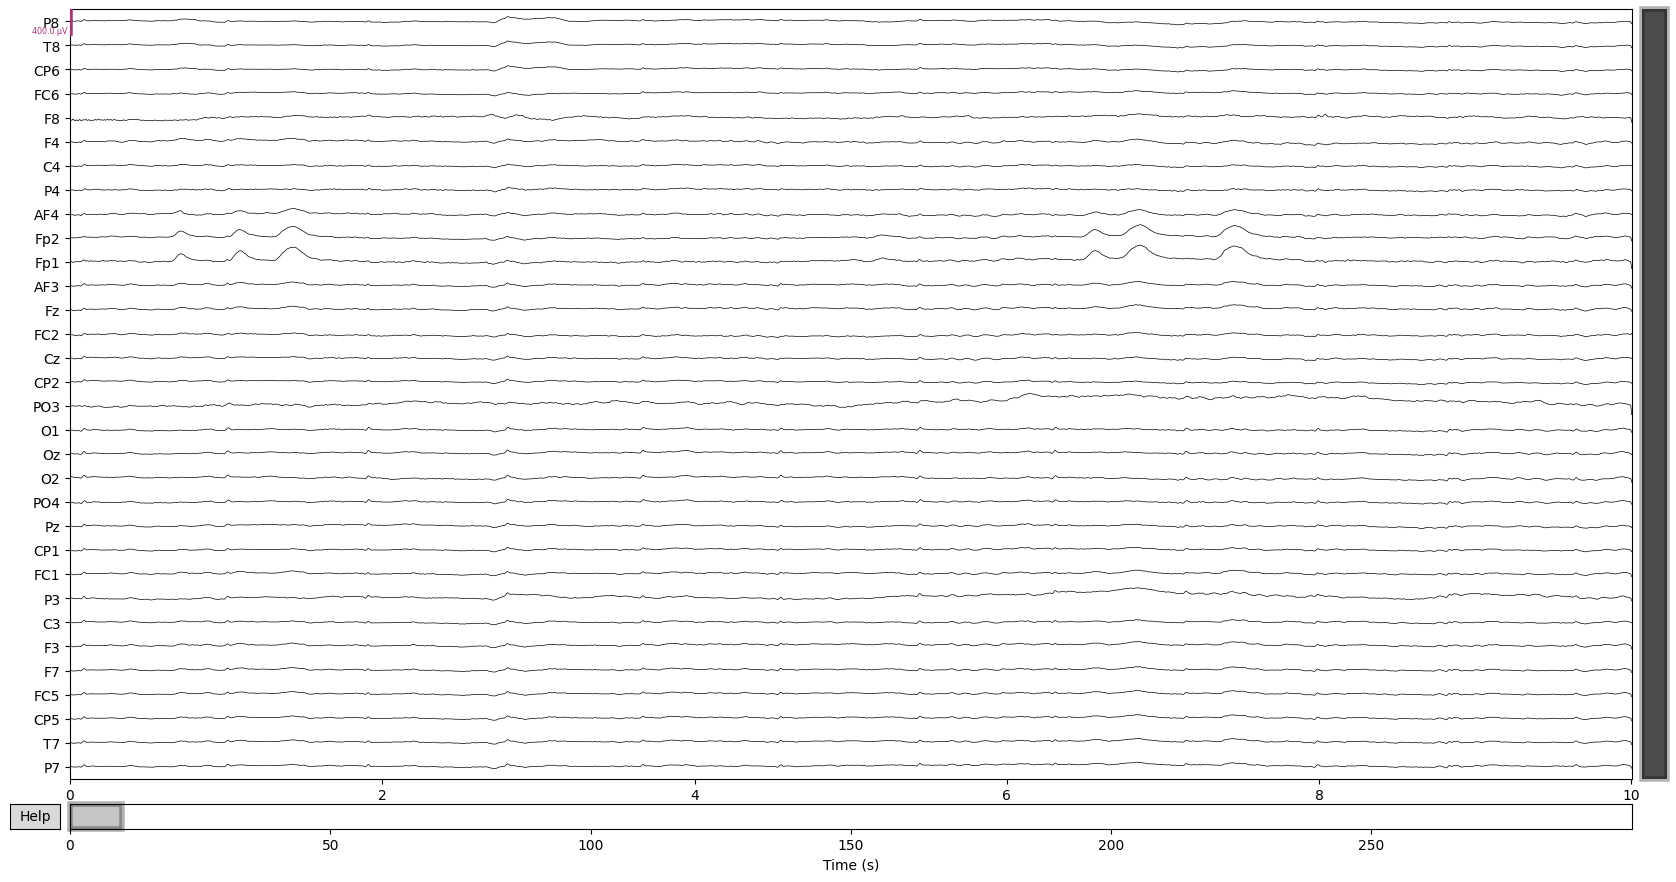

<Info | 7 non-empty values
 bads: []
 ch_names: P8, T8, CP6, FC6, F8, F4, C4, P4, AF4, Fp2, Fp1, AF3, Fz, FC2, ...
 chs: 32 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 32
 projs: []
 sfreq: 500.0 Hz
>
Effective window size : 4.096 (s)


C:\Users\vishw\AppData\Local\Temp\ipykernel_16420\1067350421.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  fig = raw.compute_psd(fmax=150,picks=all_channels).plot(picks=all_channels, exclude="bads")
c:\Users\vishw\AppData\Local\Programs\Python\Python311\Lib\site-packages\mne\viz\utils.py:161: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


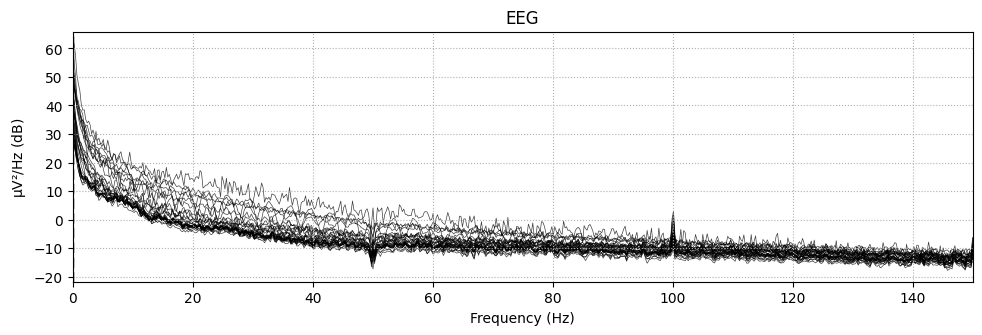

In [10]:
# raw.info['bads'] = # can set manually through interactive plot
# TODO: Code to automatically mark channels bad
raw = raw.interpolate_bads(reset_bads=False)
# title = "1--Bad channels removed"


2. Band pass filtering

In [ ]:
# applied band pass filter of 0.01-45 Hz for depression detection 
raw.filter(0.01, 45, fir_design='firwin', picks=['eeg'])
title = "2--Band pass filtered graph"
time_amplitude(title)
psd(title)

3. Rereferencing

Calculates the mean voltage from all electrodes at each time point and subtracts this mean from the voltage at each individual electrode.

In [ ]:
raw.set_eeg_reference('average', projection=True).apply_proj() 
title = "3---Rereferenced"
time_amplitude(title)
psd(title)

4. Deleting annotations - Not for first iteration


In [ ]:
# visual_inspection = pd.read_csv(directory + "Preeti singh_GoNogo_Test_2023_Jul_18_2026.csv")
# events_from_annot, event_dict = mne.events_from_annotations(raw)

# for i in range(visual_inspection.shape[0]):         
#     result = np.where((mne.events_from_annotations(raw)[0][:,0] > visual_inspection['Response.started'][i]*500) & 
#                       (mne.events_from_annotations(raw)[0][:,0] < visual_inspection['Response.stopped'][i]*500))
#     raw.annotations.delete(result)

#### 5. Artifact Rejection (EOG/ECG) using ICA


In [ ]:
from mne.preprocessing import create_ecg_epochs, create_eog_epochs, read_ica
import os.path as op
# ica_name = op.join(raw, subject, 'run_concat_highpass-%sHz-ica.fif'
#                    % (l_freq,))
ica = mne.preprocessing.ICA(
    n_components=20, max_iter="auto", random_state=97
)
ica.fit(raw)
ica.plot_components(picks=channel_names[:32])
# ica.exclude = []
ica.plot_sources(raw)

Fitting ICA to data using 32 channels (please be patient, this may take a while)
    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 20 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 5.4s.


ValueError: picks as str can only be used when measurement info is available

###### Find ECG events and score ICA components

In [ ]:
n_max_ecg = 3  # use max 3 components
ecg_epochs = create_ecg_epochs(raw, tmin=-.3, tmax=.3)
ecg_epochs.decimate(5).apply_baseline((None, None))
ecg_inds, scores_ecg = ica.find_bads_ecg(ecg_epochs, method='ctps')
print('Found %d ECG component(s)' % (len(ecg_inds),))
ica.exclude += ecg_inds[:n_max_ecg]
ica.plot_scores(scores_ecg, exclude=ecg_inds, title='ECG scores')

In [ ]:
ica.plot_sources(ecg_epochs.average(), title='ECG average')

In [ ]:
ica.plot_overlay(ecg_epochs.average())

In [ ]:
ica.plot_properties(raw, ecg_inds[:n_max_ecg])

In [ ]:
n_max_eog = 3  # use max 3 components
eog_epochs = create_eog_epochs(raw, tmin=-.5, tmax=.5)
eog_epochs.decimate(5).apply_baseline((None, None))
eog_inds, scores_eog = ica.find_bads_eog(eog_epochs)
print('Found %d EOG component(s)' % (len(eog_inds),))
ica.exclude += eog_inds[:n_max_eog]
ica.plot_scores(scores_eog, exclude=eog_inds, title='EOG scores')

In [ ]:
ica.plot_sources(eog_epochs.average(), title='EOG average')

In [ ]:
ica.plot_overlay(eog_epochs.average())

#### 6. Epoching

6.1 Adding trigger channel

In [ ]:
# events_from_annot, event_dict = mne.events_from_annotations(raw)# Get events and event_id from an Annotations object.
trigger_col = df.values[:, -2]
trigger_times = []
event_id = {}
event_list = []

for i in range(len(trigger_col)):
    if trigger_col[i]!=0:
        trigger_times.append(i+2)
        event_id[str(trigger_col[i])] = trigger_col[i]
        event_list.append(trigger_col[i])

# Create an events array (trigger value, previous, sample number)
events = np.column_stack((trigger_times, np.zeros_like(trigger_times), event_list))

In [ ]:
fig = raw.plot(n_channels=32, events=events, event_id=event_id, event_color={1:'r', 2:'g', 3:'b'}, scalings={'eeg': 2e-4})
fig.savefig(f'MNE-graphs/time-amplitude/4---Trigger channels added.png')

6.2 Remove corrupted events

In [ ]:
# Remove corrupted event
# From event_id
if '3' in event_id:
    del event_id['3']

# From events
indexes=[]
for i in range(len(events)):
    if events[i][2] == 3:
        indexes.append(i)
events = np.delete(events, indexes, 0)

fig = raw.plot(n_channels=32, events=events, event_id=event_id, event_color={1:'r', 2:'g'}, scalings={'eeg': 2e-4})
fig.savefig(f'MNE-graphs/time-amplitude/4---Trigger channels added.png')

6.3 Defining and segmenting Epochs

In [ ]:
# Applying baseline correction (mode: mean) - baseline=(tmin, 0)
# Created an SSP operator (subspace dimension = 1)
tmin = -0.1
tmax = 0.7
# gonogo - 200 msec around stimulus

# reject_criteria = dict(eeg=100e-6) # Absolute Amplitude of each epoch should be smaller than 100 μV
# Add reject_criteria=reject_criteria in mne.Epochs
epochs = mne.Epochs(raw, events=events, event_id=None, tmin=tmin, tmax=tmax, baseline=(tmin, 0), detrend=1, preload=True,picks=['eeg'])
# List of 123 epochs, with 32 (number of channels) X 401 (epoch.times)
fig = epochs.plot(n_channels=32, event_color={1:'r', 2:'g', 3:'b'}, scalings={'eeg': 2e-4}, events=events)
# fig.savefig(f'MNE-graphs/time-amplitude/5---Epochs added.png')

Applying baseline correction (mode: mean)


C:\Users\vishw\AppData\Local\Temp\ipykernel_19220\149546831.py:6: FutureWarning: The current default events=None is deprecated and will change to events=True in MNE 1.6. Set events=False to suppress this warning.
  epochs.plot()


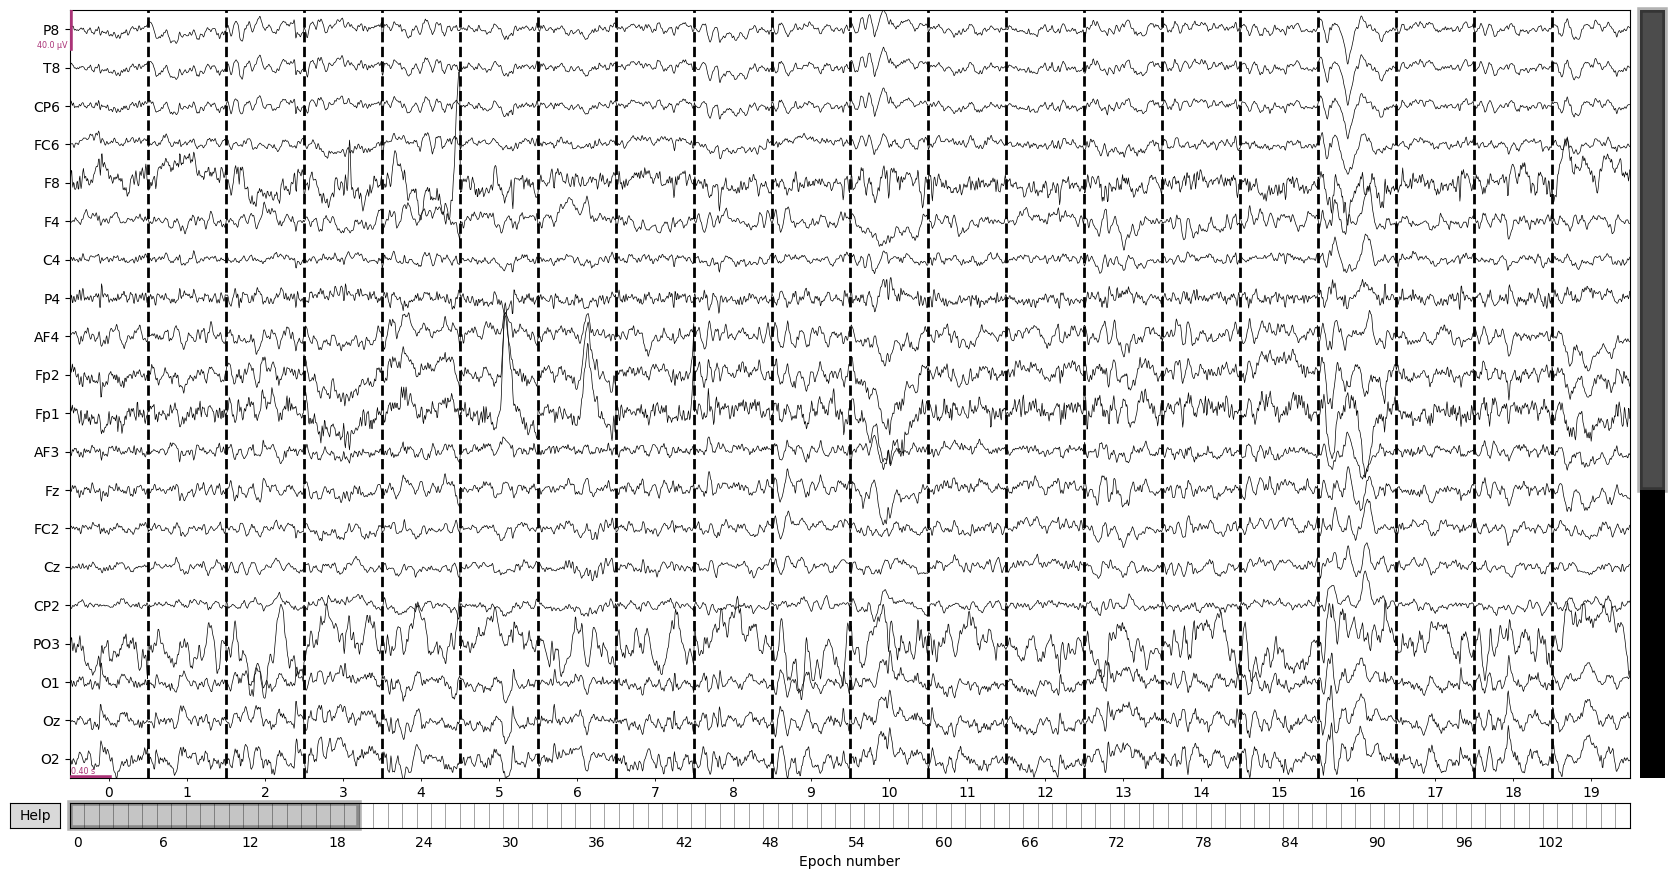

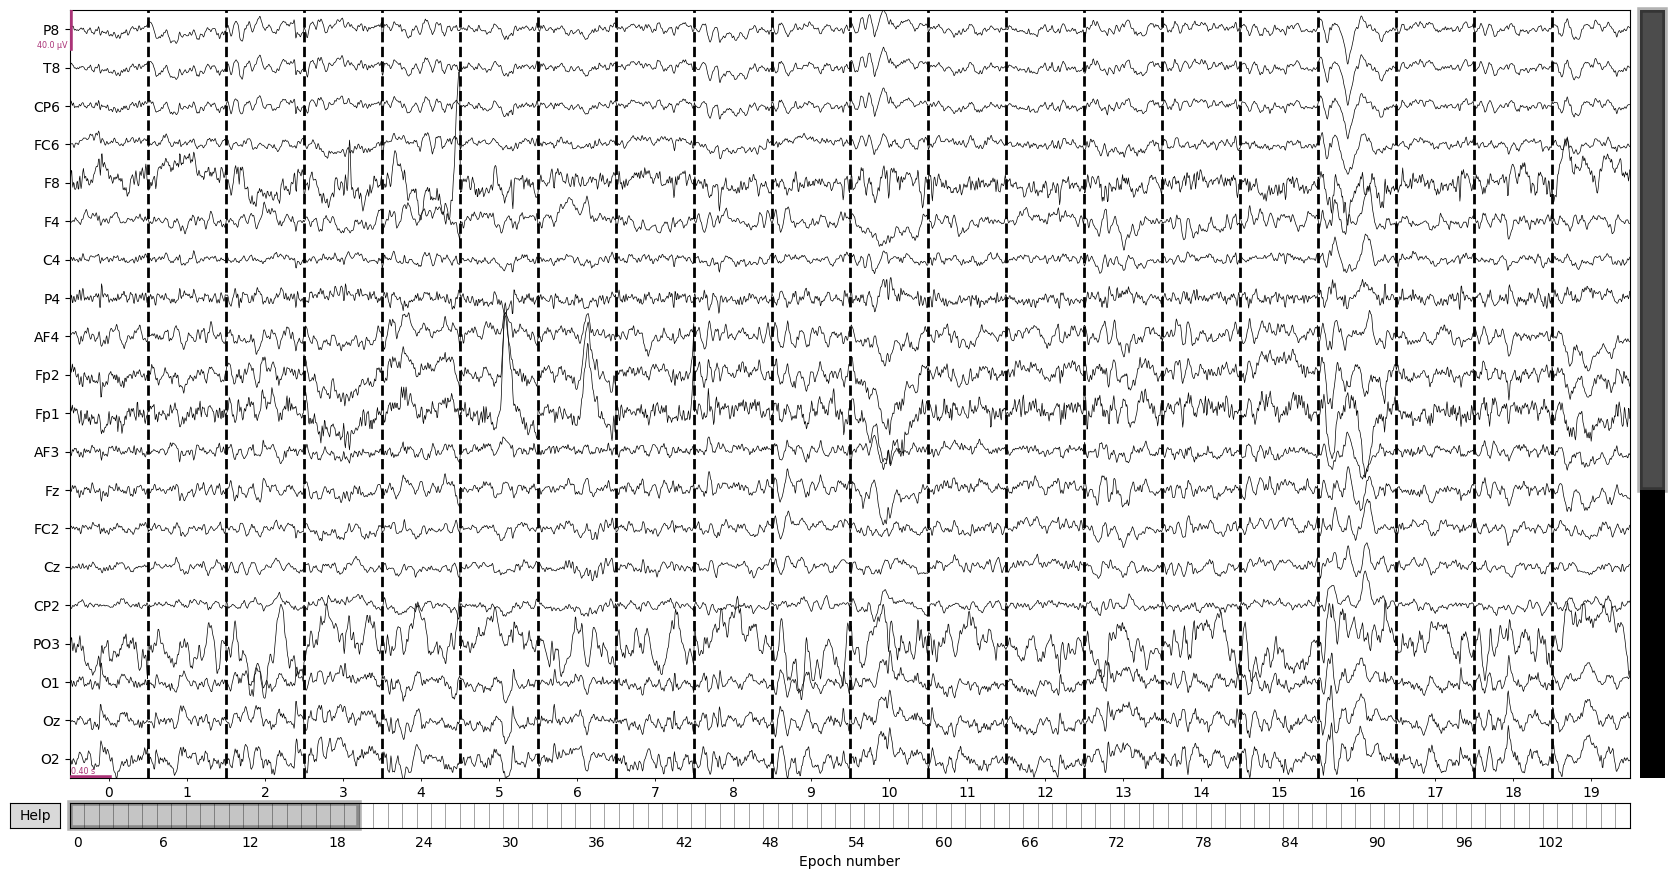

In [ ]:
# # Define the baseline period (in seconds) relative to the event onset
# baseline = (-0.1, 0.0)  # Adjust these values as needed

# # Apply baseline correction to the ERP data
# epochs.apply_baseline(baseline=baseline)
# epochs.plot()

# # Save the baseline-corrected data to a new file (optional)
# # erp.save('erp_data_baseline_corrected.fif', overwrite=True)

7. Averaging

This reduces noise and enhances signal to noise ratio

In [ ]:
individual_nogo_epoch_plots = []
individual_go_epoch_plots = []
nogo = epochs['1'].average()
go = epochs['2'].average()
# discarded = epochs['3'].average()
evokeds = dict(go=go, nogo=nogo)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


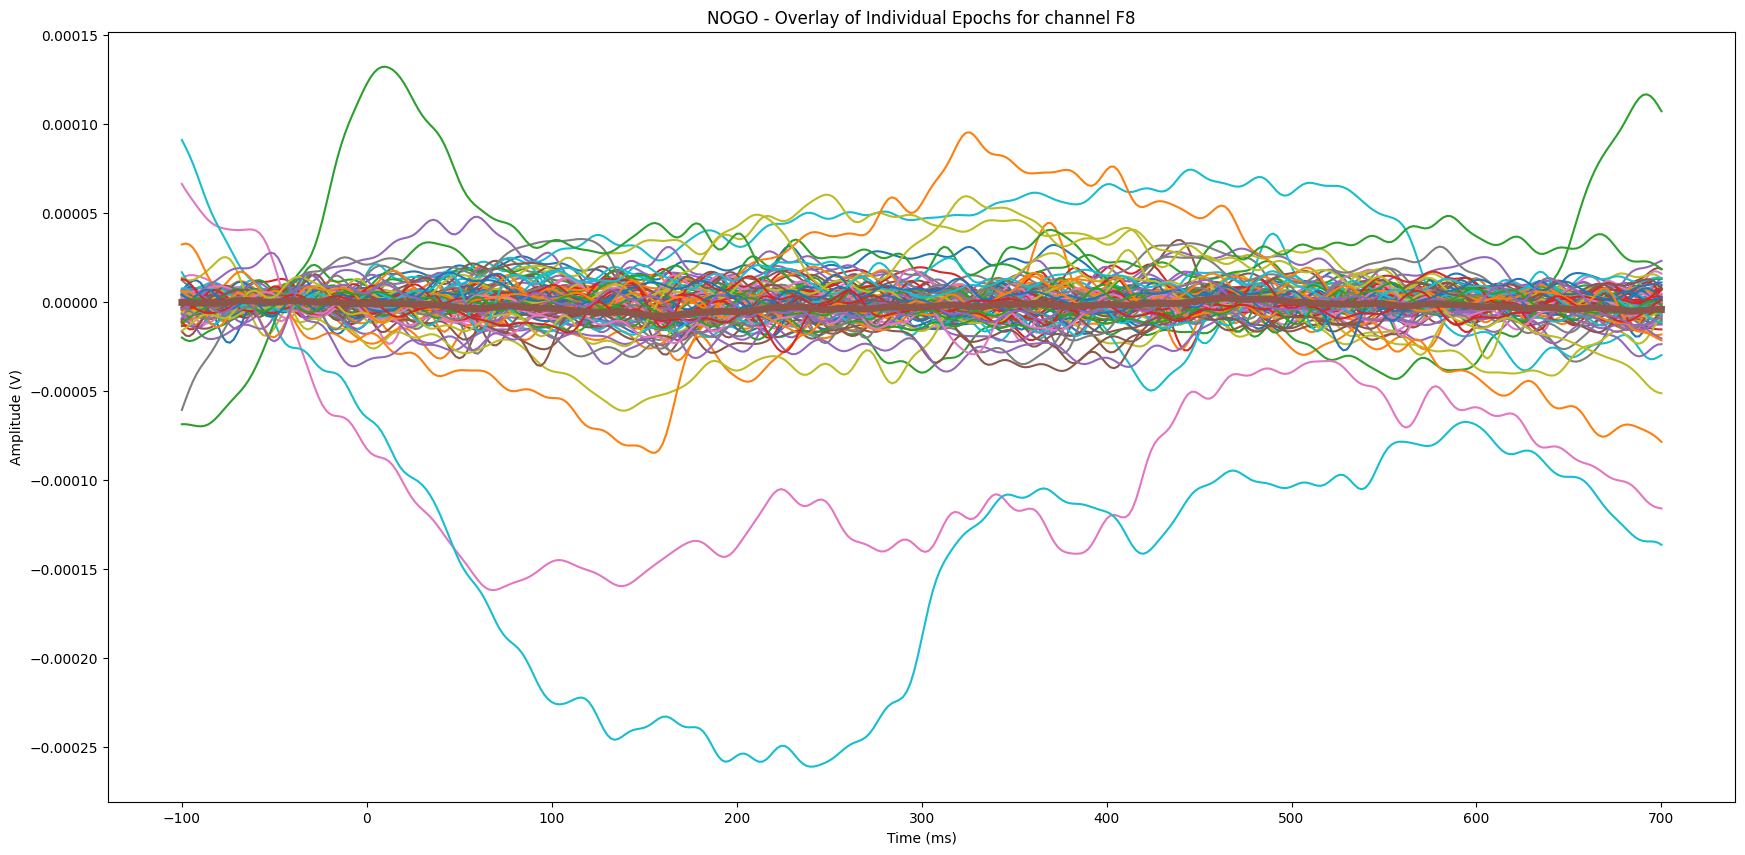

Need more than one channel to make topography for eeg. Disabling interactivity.


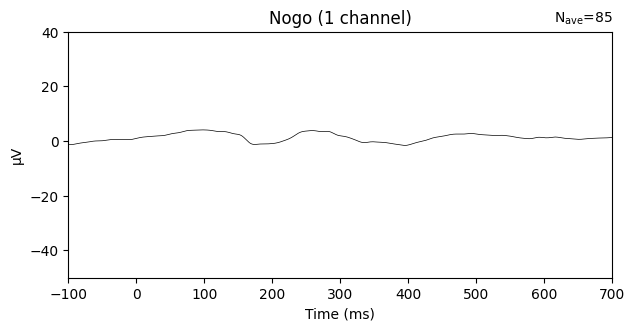

Need more than one channel to make topography for eeg. Disabling interactivity.


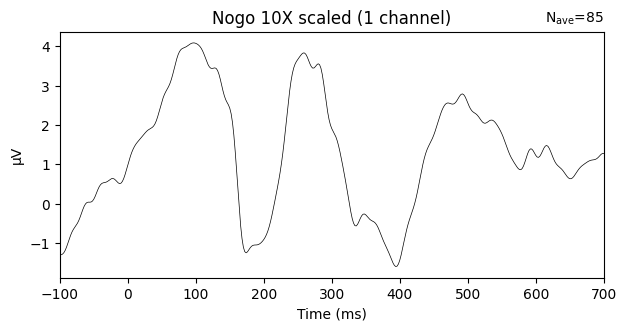

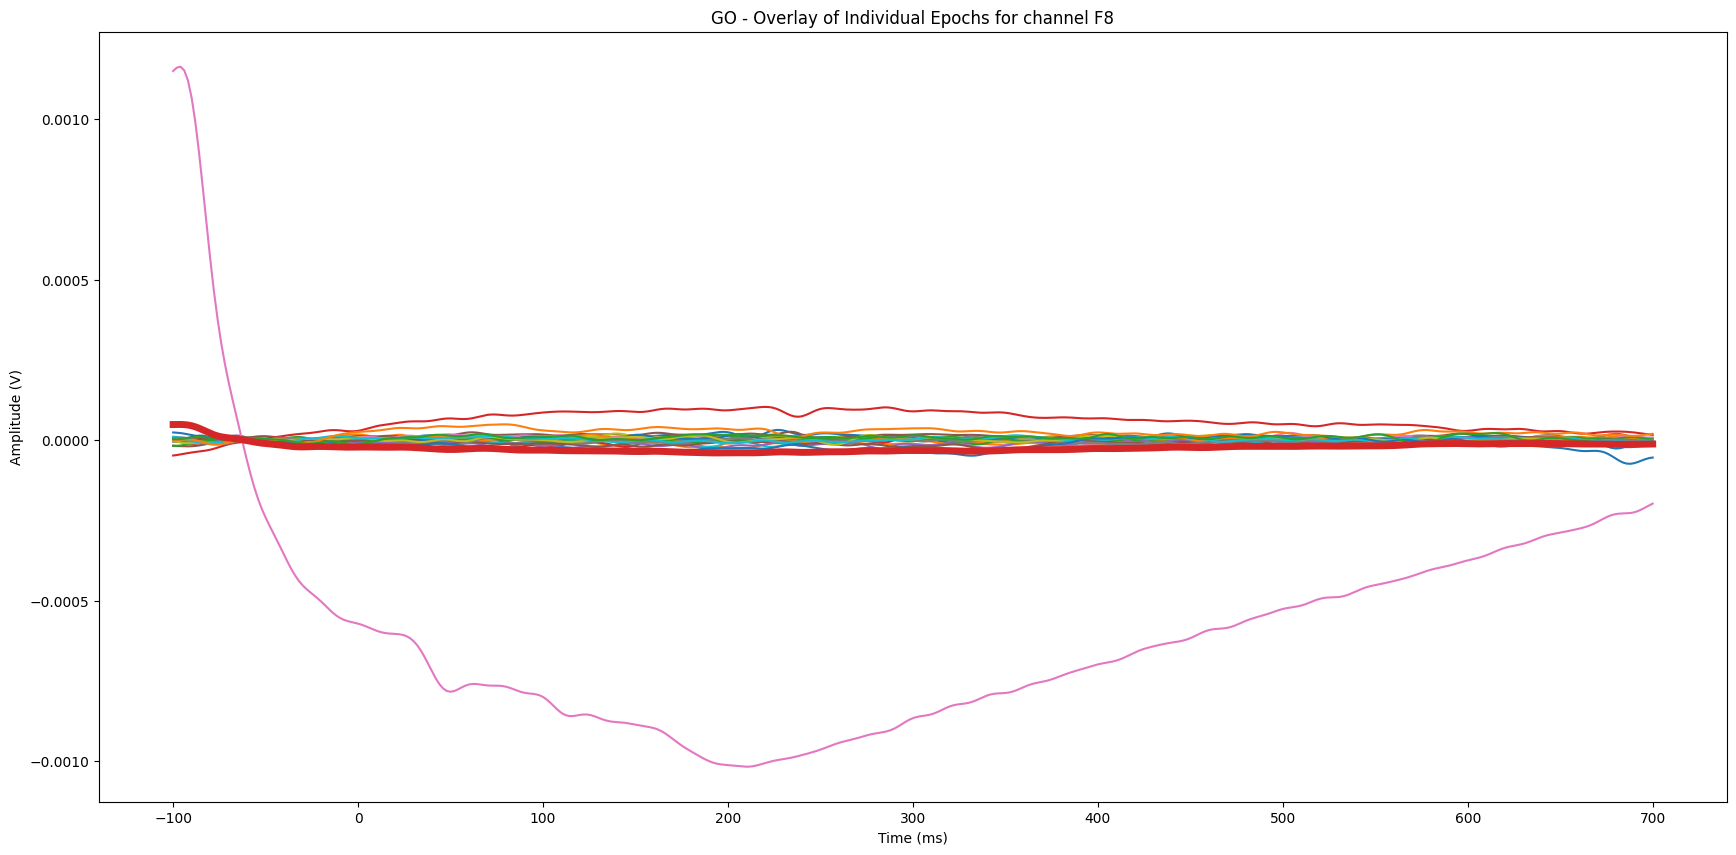

Need more than one channel to make topography for eeg. Disabling interactivity.


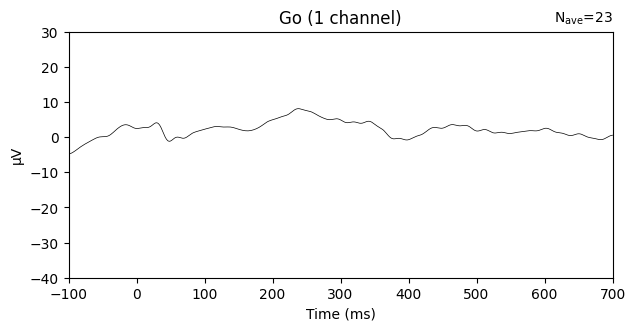

Need more than one channel to make topography for eeg. Disabling interactivity.


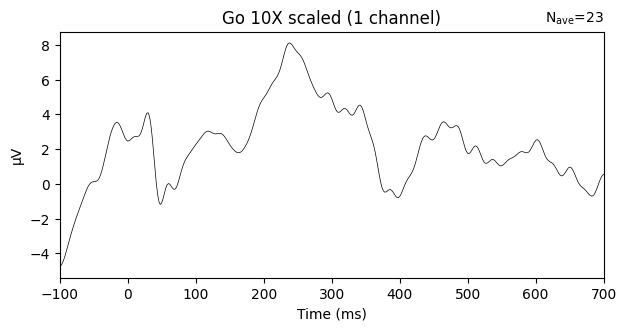

In [ ]:
nogo_data = nogo.get_data()
go_data = go.get_data()

# Convert to msec
times = epochs.times *1000 # For each epoch -- Sampling frequency (500 samples/sec) * duration of each epoch (800 msec) 
# TODO: Why times is 401 and not 400 ? Inclusive of -0.1 and 0.7 or exlcusive of what

for channel_index, channel_name in enumerate(channel_names[:32]):

    # 'F8', 'F4', 'C4', 'P4' - Frontal channels
    # 'Cz', 'C3', 'CP1' - central channels
    # 'Pz', 'F3' - Parietal channels
    gonogo_channels = ['F8', 'F4', 'C4', 'P4', 'Cz', 'C3', 'CP1', 'Pz', 'F3']
    if channel_name in gonogo_channels:
        plt.figure(figsize=(21, 10))
        for ind_epoch, epoch in enumerate(epochs):
            # print(type(epochs[ind_epoch]), type(epoch)) # <class 'mne.epochs.Epochs'> <class 'numpy.ndarray'> 32X401
            if next(iter(list(epochs[ind_epoch].event_id.values()))) == 1:
                plt.plot(times, epoch[channel_index], label=f'Epoch {ind_epoch}')
        plt.plot(times, nogo_data[channel_index], linewidth='5')
        plt.xlabel('Time (ms)')
        plt.ylabel('Amplitude (V)')
        plt.title(f'NOGO - Overlay of Individual Epochs for channel {channel_name}')
        plt.show()
        nogo.plot(picks=['P8'], titles='Nogo', ylim = dict(eeg=[-5e1, 4e1]), time_unit = 'ms')
        nogo.plot(picks=['P8'], titles='Nogo 10X scaled',  time_unit = 'ms')

        plt.figure(figsize=(21, 10))
        for ind_epoch, epoch in enumerate(epochs):
            # print(type(epochs[ind_epoch]), type(epoch)) # <class 'mne.epochs.Epochs'> <class 'numpy.ndarray'> 32X401
            if next(iter(list(epochs[ind_epoch].event_id.values()))) == 2:
                plt.plot(times, epoch[channel_index], label=f'Epoch {ind_epoch+1}')
        plt.plot(times, go_data[channel_index], linewidth='5')
        plt.xlabel('Time (ms)')
        plt.ylabel('Amplitude (V)')
        plt.title(f'GO - Overlay of Individual Epochs for channel {channel_name}')
        plt.show()
        go.plot(picks=['P8'], titles='Go', ylim = dict(eeg=[-4e1, 3e1]),  time_unit = 'ms')
        go.plot(picks=['P8'], titles='Go 10X scaled',  time_unit = 'ms')
        break


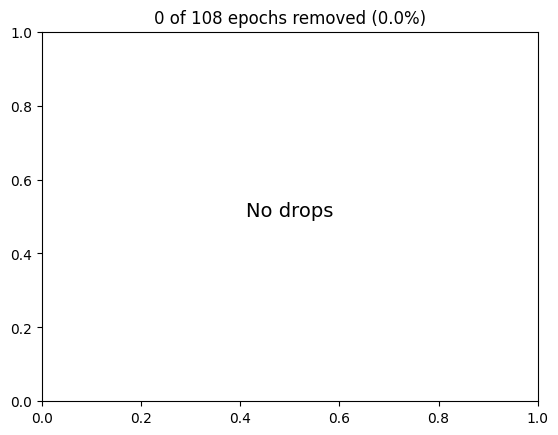

In [ ]:
# Plot dropped epochs
epochs.plot_drop_log()

In [ ]:
# plt.figure(figsize=(15, 10))

# for i in range(n_components):
#     plt.subplot(5, 7, i + 1) 
#     plt.plot(ica_result[:, i])
#     plt.title('Component {}'.format(i + 1))

# plt.tight_layout()
# plt.show()


8. ERP Components analysis

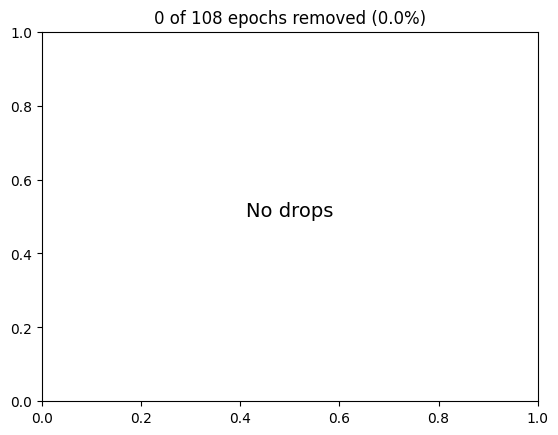

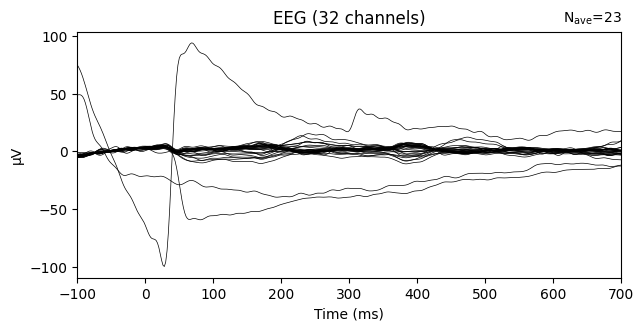

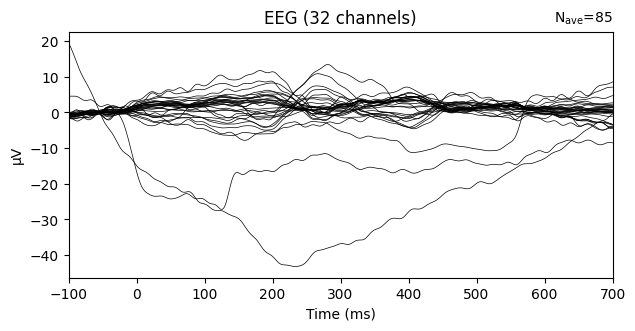

In [ ]:
evokeds = dict(go=go, nogo=nogo)
fig = go.plot(time_unit='ms')
fig.savefig(f'MNE-graphs/go-nogo/go-plot-32channels.png')
fig = nogo.plot(time_unit='ms')
fig.savefig(f'MNE-graphs/go-nogo/nogo-plot-32channels.png')

In [ ]:
# fig = mne.viz.plot_compare_evokeds(evokeds, combine="mean", time_unit='ms')
# fig[0].savefig(f'MNE-graphs/go-nogo/all-channels-averaged.png')

In [ ]:
erp_components = {'P300': [0, 250, 400], 'N2': [0, 180, 390], 'P3': [0, 250, 492]}

C:\Users\vishw\AppData\Local\Temp\ipykernel_19220\3880362177.py:4: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  fig = mne.viz.plot_compare_evokeds(evokeds, picks=channel_name, vlines=value, time_unit='ms', title=f'{key} for channel {channel_name}')


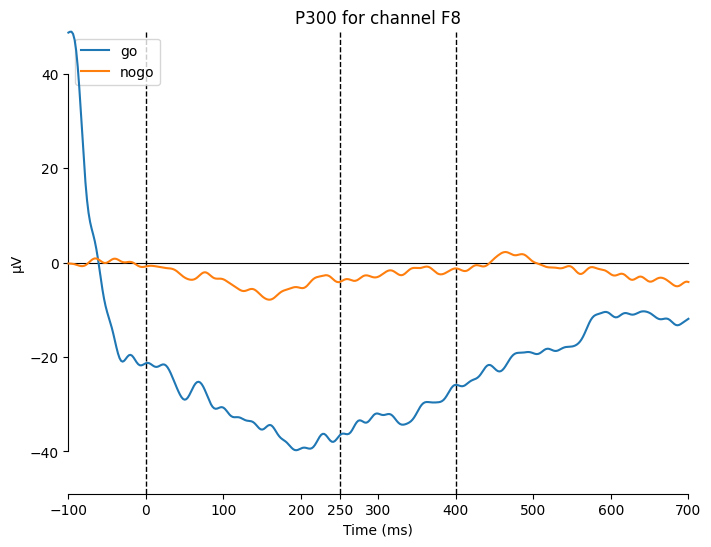

C:\Users\vishw\AppData\Local\Temp\ipykernel_19220\3880362177.py:4: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  fig = mne.viz.plot_compare_evokeds(evokeds, picks=channel_name, vlines=value, time_unit='ms', title=f'{key} for channel {channel_name}')


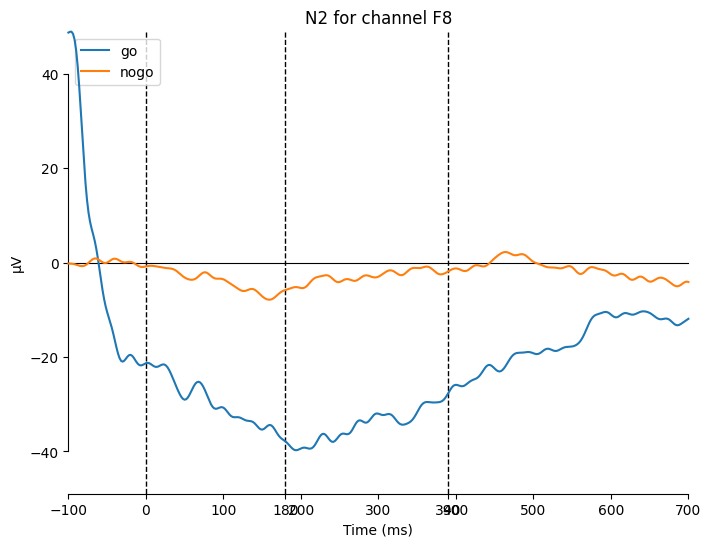

C:\Users\vishw\AppData\Local\Temp\ipykernel_19220\3880362177.py:4: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  fig = mne.viz.plot_compare_evokeds(evokeds, picks=channel_name, vlines=value, time_unit='ms', title=f'{key} for channel {channel_name}')


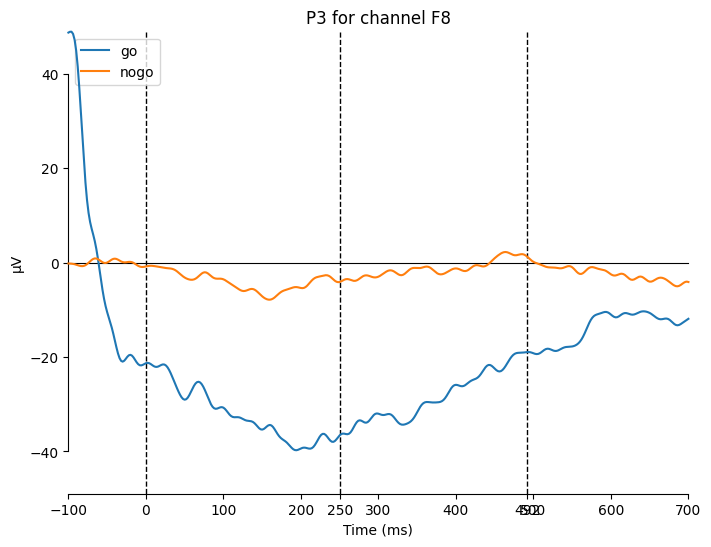

In [ ]:
for key, value in erp_components.items():
    for channel_name in gonogo_channels:
        # TODO: cross check what combine is !!!! it should be combining all epochs for 1 channel not more than 1 channels together
        fig = mne.viz.plot_compare_evokeds(evokeds, picks=channel_name, vlines=value, time_unit='ms', title=f'{key} for channel {channel_name}')
        # fig[0].savefig(f'MNE-graphs/go-nogo/{channel_name}.png')

        break

C:\Users\vishw\AppData\Local\Temp\ipykernel_19220\1943733488.py:4: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  fig = mne.viz.plot_compare_evokeds(evokeds, picks=channel_name, vlines=[0], time_unit='ms', title=f'ERP analysis for channel {channel_name}')


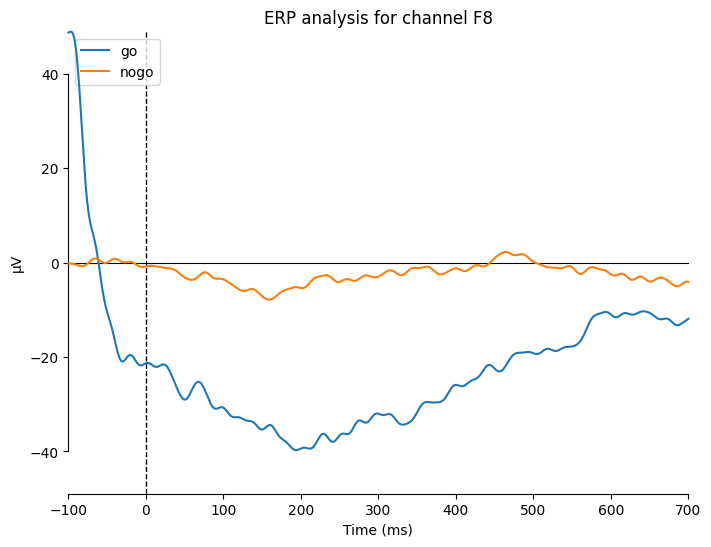

C:\Users\vishw\AppData\Local\Temp\ipykernel_19220\1943733488.py:4: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  fig = mne.viz.plot_compare_evokeds(evokeds, picks=channel_name, vlines=[0], time_unit='ms', title=f'ERP analysis for channel {channel_name}')


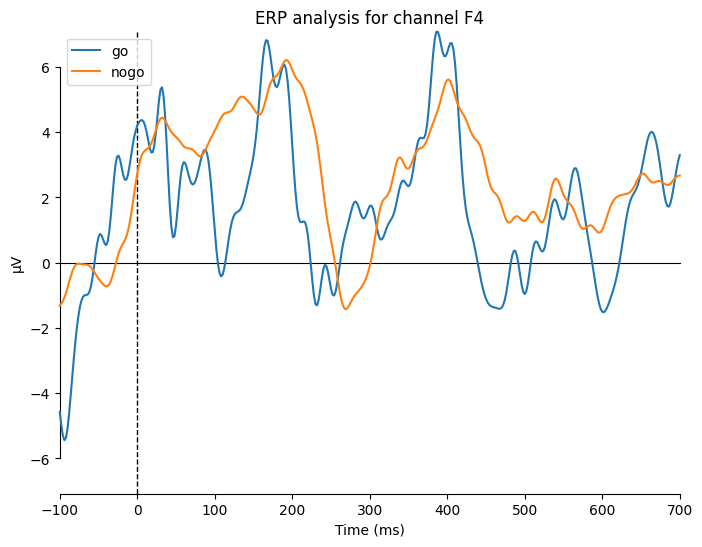

C:\Users\vishw\AppData\Local\Temp\ipykernel_19220\1943733488.py:4: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  fig = mne.viz.plot_compare_evokeds(evokeds, picks=channel_name, vlines=[0], time_unit='ms', title=f'ERP analysis for channel {channel_name}')


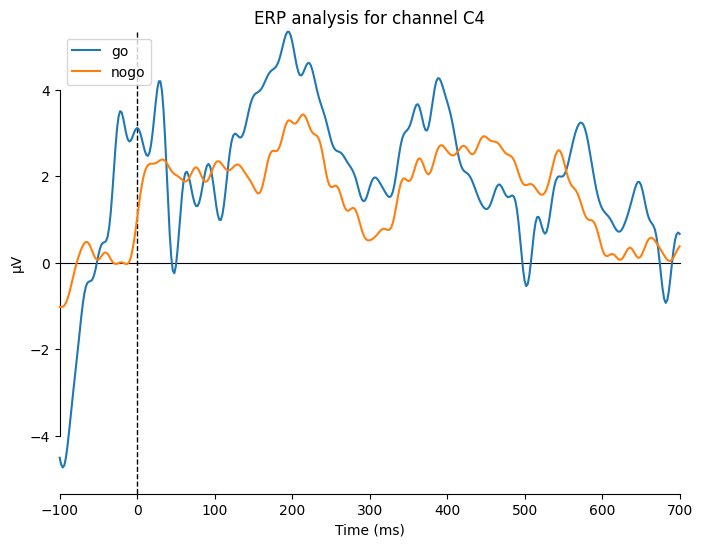

C:\Users\vishw\AppData\Local\Temp\ipykernel_19220\1943733488.py:4: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  fig = mne.viz.plot_compare_evokeds(evokeds, picks=channel_name, vlines=[0], time_unit='ms', title=f'ERP analysis for channel {channel_name}')


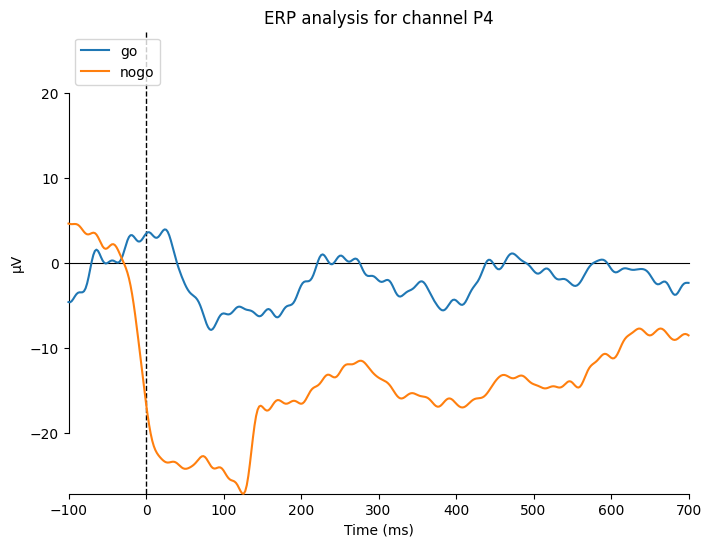

C:\Users\vishw\AppData\Local\Temp\ipykernel_19220\1943733488.py:4: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  fig = mne.viz.plot_compare_evokeds(evokeds, picks=channel_name, vlines=[0], time_unit='ms', title=f'ERP analysis for channel {channel_name}')


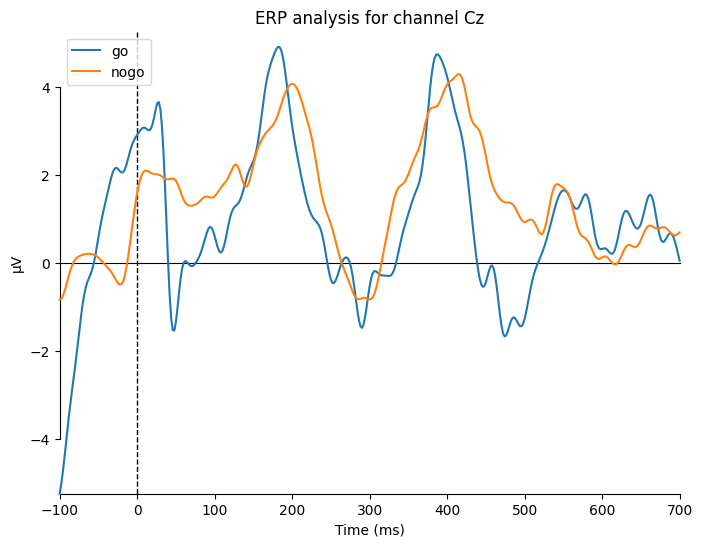

C:\Users\vishw\AppData\Local\Temp\ipykernel_19220\1943733488.py:4: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  fig = mne.viz.plot_compare_evokeds(evokeds, picks=channel_name, vlines=[0], time_unit='ms', title=f'ERP analysis for channel {channel_name}')


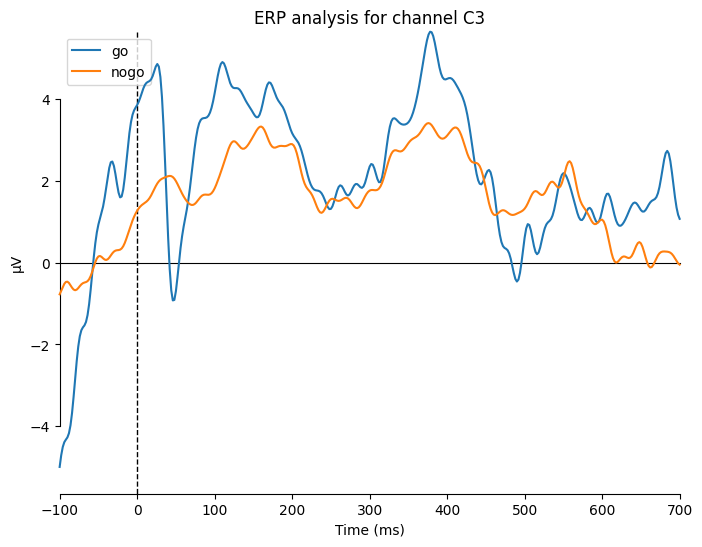

C:\Users\vishw\AppData\Local\Temp\ipykernel_19220\1943733488.py:4: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  fig = mne.viz.plot_compare_evokeds(evokeds, picks=channel_name, vlines=[0], time_unit='ms', title=f'ERP analysis for channel {channel_name}')


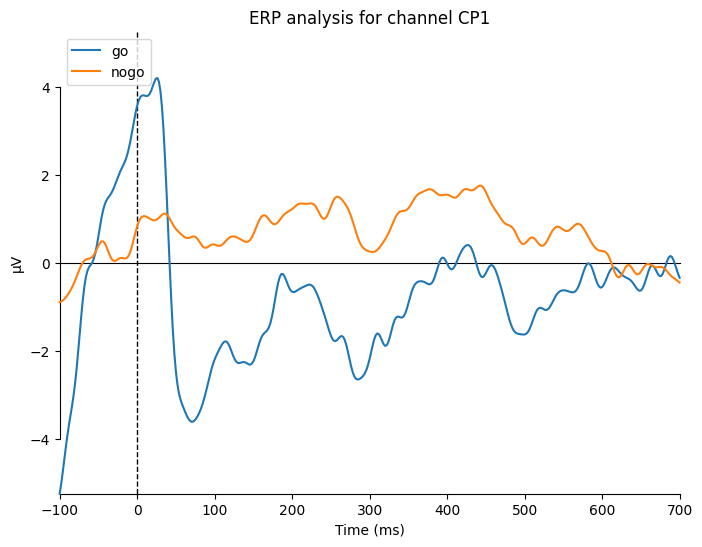

C:\Users\vishw\AppData\Local\Temp\ipykernel_19220\1943733488.py:4: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  fig = mne.viz.plot_compare_evokeds(evokeds, picks=channel_name, vlines=[0], time_unit='ms', title=f'ERP analysis for channel {channel_name}')


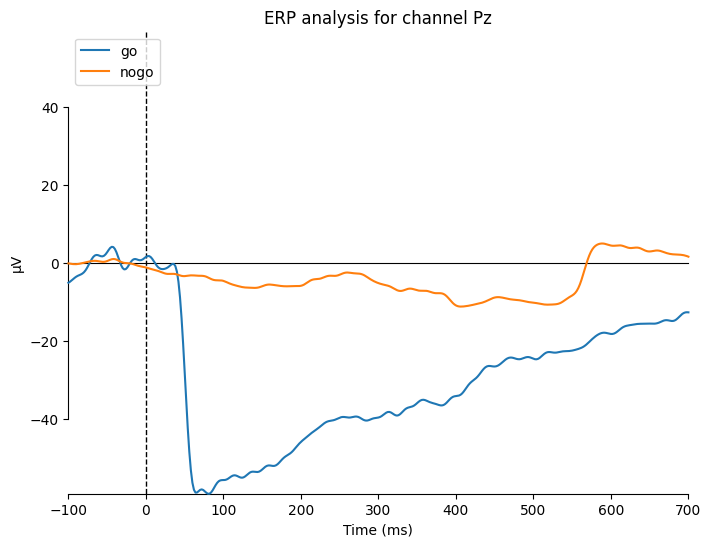

C:\Users\vishw\AppData\Local\Temp\ipykernel_19220\1943733488.py:4: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  fig = mne.viz.plot_compare_evokeds(evokeds, picks=channel_name, vlines=[0], time_unit='ms', title=f'ERP analysis for channel {channel_name}')


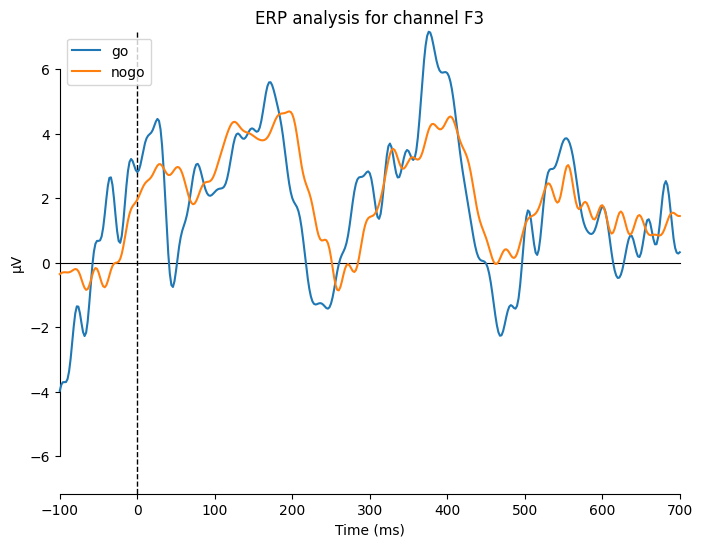

In [ ]:
gonogo_channels = ['F8', 'F4', 'C4', 'P4', 'Cz', 'C3', 'CP1', 'Pz', 'F3']
# for key, value in erp_components.items():
for channel_name in gonogo_channels:
    fig = mne.viz.plot_compare_evokeds(evokeds, picks=channel_name, vlines=[0], time_unit='ms', title=f'ERP analysis for channel {channel_name}')
    fig[0].savefig(f'MNE-graphs/go-nogo/{channel_name} {patient}')

In [ ]:
# GFP plot - # TODO: Use ?
# for evk in (nogo, go):
#     evk.plot(gfp=True, scalings={'eeg': 1e5}, spatial_colors=True)

In [ ]:
# import pandas as pd

# folder_path = 'E:/IITD/Depression-IITD/Depression-Sample-dataset-AIIMS/'
# sham_or_active = 'Active/' # Active
# patient = 'Preeti singh/'
# pre_post_intervention = 'intervention/'
# directory = folder_path + sham_or_active + patient + pre_post_intervention
# file_path = directory + '20230718203907_Preeti singh_22.08.23_01_STIM.easy'

# df = pd.read_csv(file_path, sep='\t')
# x = df.values[:, -2]

# res=[]
# for i in x:
#     if i!=0:
#         res.append(i)

# print(res)

# transposed_data=df.T

# # Create a MNE-Python info object and specifying sampling rate of data
# ch_names = df.columns.tolist()[:-5]
# ch_types = ['eeg' for i in range(32)]
# info = mne.create_info(ch_names=ch_names,ch_types=ch_types, sfreq=500)

# # Create a Raw object from the DataFrame
# raw = mne.io.RawArray(transposed_data.values[:-5,:], info)

# # Bandpass butterworth filter added
# # Cutoffs at 0.01, 45.00 Hz: -6.02, -6.02 dB
# # Applied only in currently plot
# fig = raw.plot(n_channels=32, 
# lowpass=45, 
# highpass=0.01,
# scalings={'eeg': 1e6} 
# )

AO - triggers --- ERP related
GNG - triggers --- ERP related 
Eye open/eye close - No triggers
Stim - No triggers
